In [10]:
# Bloques basicos
import sionna
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Parametros basicos
eps = 1e-12 # pequeña constante para evitar divisiones por cero
sionna.phy.config.seed = 0 # semilla aleatoria
N = 128 # longitud del código
K = 64 # número de bits de información
lote_prueba = 500 # tamaño del batch
snr_prueba = 4.0 # SNR en dB para la simulación de prueba
bitsxsimb = 1 # bits por símbolo (BPSK)
if bitsxsimb == 1:
    modulacion = "pam" # +1+0j y -1+0j para BPSK
else:
    modulacion = "qam" # QAM para más bits por símbolo
bloq_inter = 1 # Numero de bloques de interleaving (1 = sin interleaving)
list_scl = 8 # tamaño de lista para decodificador SCL
LLR_clip = 1000 # valor de recorte para LLRs

# Clases comunes
datos = sionna.phy.mapping.BinarySource() # generador de datos aleatorios
constelacion = sionna.phy.mapping.Constellation(modulacion, bitsxsimb) # define la constelacion
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion) # bits a simbolos
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion) # inverso del mapeador
interleaver = sionna.phy.fec.interleaving.RandomInterleaver(seed=0, axis=1) # interleaver a nivel de bloq_inter
deinterleaver = sionna.phy.fec.interleaving.Deinterleaver(interleaver) # inverso del interleaver

b: tf.Tensor([1. 1. 0.], shape=(3,), dtype=float32)
x: tf.Tensor([-1.+0.j -1.+0.j  1.+0.j], shape=(3,), dtype=complex64)
y: tf.Tensor([-1.0459139 -0.08858193j -0.06913936+0.5696364j   1.1388382 +0.3854556j ], shape=(3,), dtype=complex64)
b_hat: tf.Tensor([1. 1. 0.], shape=(3,), dtype=float32)
err: 389


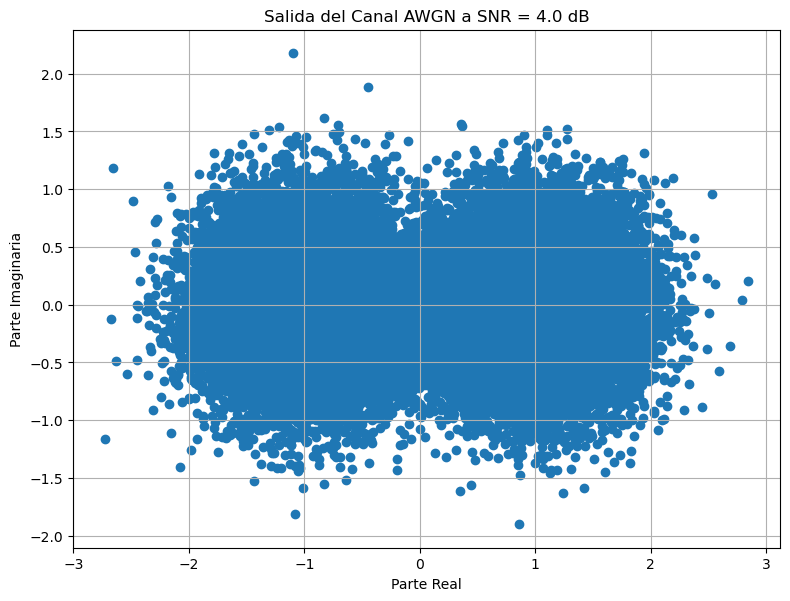

In [11]:
# Simulacion AWGN sin codigo de canal

# Transmision
b = datos([lote_prueba, K])
x = mapeador(b)

# Canal AWGN
no = sionna.phy.utils.ebnodb2no(snr_prueba, bitsxsimb, coderate=1.0)
awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
awgn = tf.complex(awgn_real, awgn_imag)
y = x + awgn

# Recepcion
llr = demapeador(y, no)
b_hat = sionna.phy.utils.hard_decisions(llr)

# Grafico de y
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Salida del Canal AWGN a SNR = {} dB'.format(snr_prueba))
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

# Prueba de variables y errores
dim_hor = 3 # numero de bits de bloque
dim_ver = 1 # numero de bloques de interleaving
print("b:", b[0, :dim_hor])
print("x:", x[0, :dim_hor])
print("y:", y[0, :dim_hor])
print("b_hat:", b_hat[0, :dim_hor])
err = tf.math.count_nonzero(tf.not_equal(b, b_hat), dtype=tf.int32)
print("err:", int(err.numpy()))

b: tf.Tensor([0. 0. 0. 0. 0. 1. 0. 1.], shape=(8,), dtype=float32)
x: tf.Tensor([ 1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j -1.+0.j  1.+0.j -1.+0.j], shape=(8,), dtype=complex64)
y: tf.Tensor(
[ 0.5066044 +0.09127669j  0.37799603+0.00467528j  0.34795249+0.11561254j
  0.28769666+0.05879565j  0.28958413+0.01718946j -0.37799722-0.10071169j
  0.35731477+0.13811265j -0.356506  -0.00186669j], shape=(8,), dtype=complex64)
b_hat: tf.Tensor([0. 0. 0. 0. 0. 1. 0. 1.], shape=(8,), dtype=float32)
err: 72


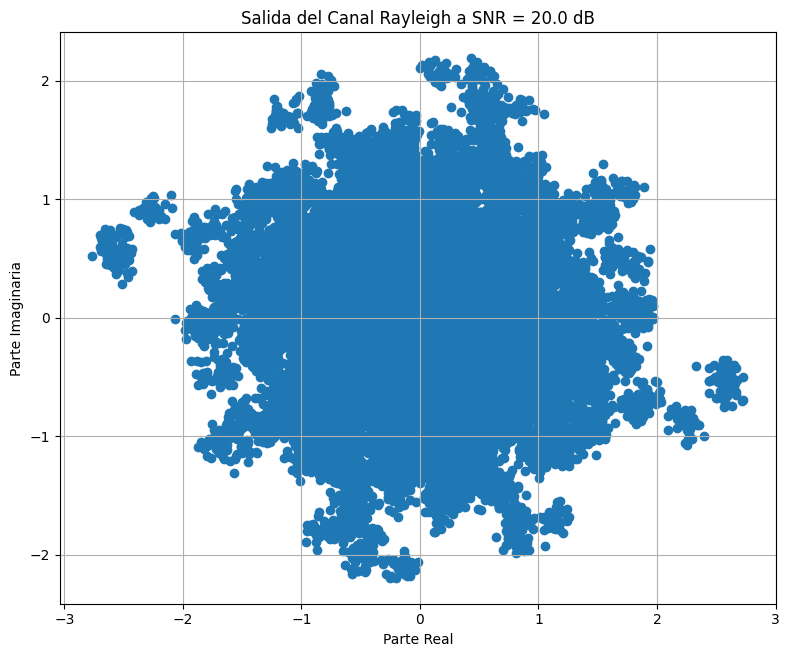

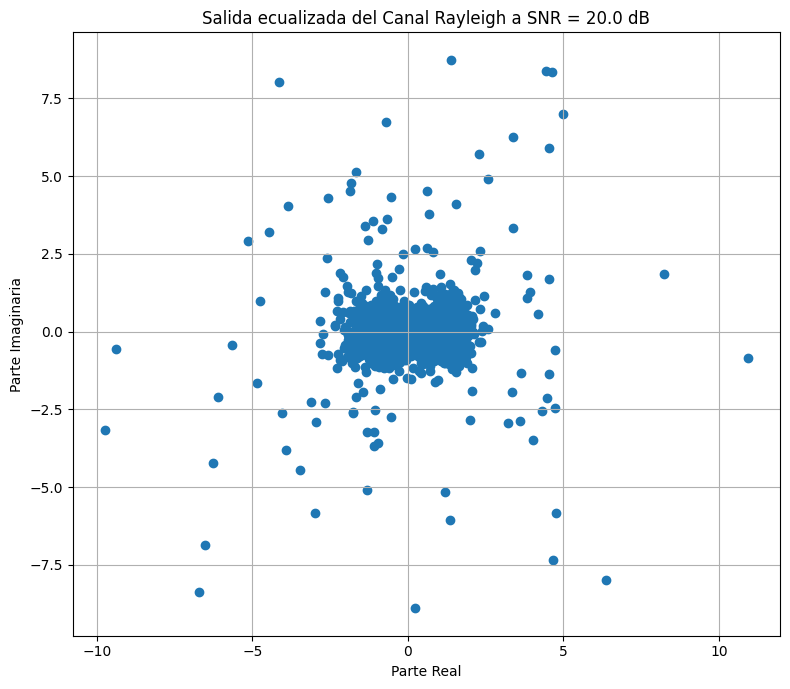

In [23]:
# Prueba el correcto funcionamiento del sistema con canal Rayleigh

# Transmision
b = datos([lote_prueba, K]) # otra opcion contra el desvanecimiento plano es usar diversidad
# b_int = interleaver(b)
x = mapeador(b)

# Canal Rayleigh con desvanecimiento plano en N
no = sionna.phy.utils.ebnodb2no(snr_prueba, bitsxsimb, coderate=1.0) # sin codigo de canal
awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
awgn = tf.complex(awgn_real, awgn_imag) # desviacion estandar no
h_real = sionna.phy.config.tf_rng.normal([lote_prueba], stddev=tf.sqrt(0.5), dtype=tf.float32)
h_imag = sionna.phy.config.tf_rng.normal([lote_prueba], stddev=tf.sqrt(0.5), dtype=tf.float32)
h = tf.expand_dims(tf.complex(h_real, h_imag), -1) # desviacion estandar 1
y = h * x + awgn

# Recepcion (con ecualizacion MMSE)
# g = tf.math.conj(h) / tf.cast(tf.math.square(tf.abs(h)) + no, tf.complex64)
# d = g * h
# d_abs = tf.maximum(tf.abs(d), 1e-12)
# x_hat = g * y / tf.cast(d_abs, tf.complex64)
# no_eff = no / tf.maximum(tf.math.square(tf.abs(h)), 1e-12)

# Recepcion (con ecualizacion MMSE)
h2 = tf.maximum(tf.math.square(tf.abs(h)), eps)
x_hat = y * tf.math.conj(h) / tf.cast(h2, tf.complex64)
no_eff = no / tf.maximum(h2, eps)

llr = demapeador(x_hat, no_eff)
# llr_deint = deinterleaver(llr)
b_hat = sionna.phy.utils.hard_decisions(llr)

# Grafico de y
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Salida del Canal Rayleigh a SNR = {} dB'.format(snr_prueba))
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

# Grafico de y ecualizado
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Salida ecualizada del Canal Rayleigh a SNR = {} dB'.format(snr_prueba))
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.scatter(tf.math.real(x_hat), tf.math.imag(x_hat))
plt.tight_layout()

# Prueba de variables y errores
dim_hor = 8 # numero de bits de bloque
print("b:", b[0, :dim_hor])
print("x:", x[0, :dim_hor])
print("y:", y[0, :dim_hor])
print("b_hat:", b_hat[0, :dim_hor])
err = tf.math.count_nonzero(tf.not_equal(b, b_hat), dtype=tf.int32)
print("err:", int(err.numpy()))